## Model Training for Fraud Detection & Risk Analytics

### Data Preprocessing

Let us import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('Cleaned_Data/creditcard_cleaned.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V26,V27,V28,Amount,Class,TransactionDate,Hour,ElapsedDays,Hour_sin,Hour_cos
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.189115,0.133558,-0.021053,149.62,0,2020-01-01 00:00:00,0,0,0.0,1.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.125895,-0.008983,0.014724,2.69,0,2020-01-01 00:00:00,0,0,0.0,1.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.139097,-0.055353,-0.059752,378.66,0,2020-01-01 00:00:01,0,0,0.0,1.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.221929,0.062723,0.061458,123.50,0,2020-01-01 00:00:01,0,0,0.0,1.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.502292,0.219422,0.215153,69.99,0,2020-01-01 00:00:02,0,0,0.0,1.0


### Scale the features

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['Amount', 'ElapsedDays', 'Time']] = scaler.fit_transform(df[['Amount', 'ElapsedDays', 'Time']])

### Split the data into train and test sets

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Class', 'TransactionDate'])  # exclude target and datetime
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Handling class imbalance

In [8]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())


Before SMOTE: Class
0    227451
1       394
Name: count, dtype: int64
After SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64


## Now, we can proceed towards model training

### Base Model Training

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve

In [2]:
# Load the dataset
df = pd.read_csv('Cleaned_Data/creditcard_cleaned.csv')

# Define feature columns
numeric_features = ['Time', 'ElapsedDays', 'Amount']
pcs_features = [f'V{i}' for i in range(1, 29)]
cyclic_features = ['Hour_sin', 'Hour_cos']

feature_cols = numeric_features + pcs_features + cyclic_features

X = df[feature_cols]
y = df['Class']

### Let us split the data into train and test sets

In [3]:
# Train Test Split with Stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Next step, preprocessing data

In [4]:
# Preprocessing pipeline for numeric features
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers= [
        ('num', numeric_transformer, numeric_features),
        ('pass_pca', 'passthrough', pcs_features),
        ('pass_cyclic', 'passthrough', cyclic_features)
    ]
)

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

### Handline class imbalance

In [5]:
## Use SMOTETomek to balance the classes

sm = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_preprocessed, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())

Before SMOTE: Class
0    227451
1       394
Name: count, dtype: int64
After SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64


In [6]:
def evaluate_model(true, predicted, proba=None):
    acc = accuracy_score(true, predicted)
    f1 = f1_score(true, predicted)
    roc = roc_auc_score(true, proba if proba is not None else predicted)
    fpr, tpr, thresholds = roc_curve(true, proba if proba is not None else predicted)
    return acc, f1, roc, fpr, tpr, thresholds

In [12]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

# Define classification models
models = {
    "Logistic Regression": LogisticRegression(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "XGBClassifier": XGBClassifier(tree_method='gpu_hist', device = 'cuda'),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "CatBoostClassifier": CatBoostClassifier(task_type="GPU", devices='0')
}

In [13]:
# Create DataFrames to store the results
train_results = pd.DataFrame(columns=['Model', 'F1 Score', 'ROC AUC', 'Accuracy'])
test_results = pd.DataFrame(columns=['Model', 'F1 Score', 'ROC AUC', 'Accuracy'])

# Train and evaluate models
for model_name, model in models.items():
    print(f"Training {model_name}...")

    model.fit(X_train_resampled, y_train_resampled)

    train_pred = model.predict(X_train_resampled)
    test_pred = model.predict(X_test_preprocessed)

    # Use predicted probabilities for ROC AUC
    train_proba = model.predict_proba(X_train_resampled)[:, 1] if hasattr(model, 'predict_proba') else None
    test_proba = model.predict_proba(X_test_preprocessed)[:, 1] if hasattr(model, 'predict_proba') else None

    train_acc, train_f1, train_roc, train_fpr, train_tpr, train_tresh = evaluate_model(y_train_resampled, train_pred, train_proba)
    test_acc, test_f1, test_roc, test_fpr, test_tpr, test_tresh = evaluate_model(y_test, test_pred, test_proba)

    train_results.loc[len(train_results)] = [model_name, train_f1, train_roc, train_acc]
    test_results.loc[len(test_results)] = [model_name, test_f1, test_roc, test_acc]

Training Logistic Regression...
Training KNeighborsClassifier...
Training RandomForestClassifier...
Training AdaBoost...
Training GradientBoostingClassifier...
Training XGBClassifier...


/home/anupam9k/AI_Resume_Projects/Fraud_Detection_&_Risk_Analytics_for_FinTehcs_&_SMEs/fdenv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:19:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/anupam9k/AI_Resume_Projects/Fraud_Detection_&_Risk_Analytics_for_FinTehcs_&_SMEs/fdenv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [12:19:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/home/anupam9k/AI_Resume_Projects/Fraud_Detection_&_Risk_Analytics_for_FinTehcs_&_SMEs/fdenv/lib/python3.10/site-pack

Training DecisionTreeClassifier...
Training CatBoostClassifier...
Learning rate set to 0.024076
0:	learn: 0.6411828	total: 93.5ms	remaining: 1m 33s
1:	learn: 0.5940659	total: 104ms	remaining: 51.8s
2:	learn: 0.5540995	total: 114ms	remaining: 37.9s
3:	learn: 0.5173892	total: 123ms	remaining: 30.7s
4:	learn: 0.4795679	total: 133ms	remaining: 26.5s
5:	learn: 0.4497770	total: 144ms	remaining: 23.9s
6:	learn: 0.4189222	total: 154ms	remaining: 21.8s
7:	learn: 0.3939220	total: 163ms	remaining: 20.2s
8:	learn: 0.3736126	total: 172ms	remaining: 19s
9:	learn: 0.3511105	total: 182ms	remaining: 18s
10:	learn: 0.3335631	total: 190ms	remaining: 17.1s
11:	learn: 0.3100146	total: 200ms	remaining: 16.5s
12:	learn: 0.2935624	total: 211ms	remaining: 16s
13:	learn: 0.2813377	total: 219ms	remaining: 15.4s
14:	learn: 0.2668378	total: 229ms	remaining: 15.1s
15:	learn: 0.2549400	total: 238ms	remaining: 14.6s
16:	learn: 0.2446517	total: 247ms	remaining: 14.3s
17:	learn: 0.2353389	total: 256ms	remaining: 13.9s


#### These are the training results

In [14]:
train_results = train_results.sort_values(by = "Accuracy", ascending=False).reset_index(drop = True)
train_results

,Model,F1 Score,ROC AUC,Accuracy
0,RandomForestClassifier,1.000000,1.000000,1.000000
1,XGBClassifier,1.000000,1.000000,1.000000
2,DecisionTreeClassifier,1.000000,1.000000,1.000000
3,CatBoostClassifier,0.999881,0.999999,0.999881
4,KNeighborsClassifier,0.999411,1.000000,0.999411
5,GradientBoostingClassifier,0.989296,0.999500,0.989336
6,Logistic Regression,0.955448,0.993085,0.956208
7,AdaBoost,0.952426,0.993332,0.953425


#### These are the test results

In [15]:
test_results = test_results.sort_values(by = "Accuracy", ascending=False).reset_index(drop = True)
test_results

,Model,F1 Score,ROC AUC,Accuracy
0,XGBClassifier,0.882051,0.976249,0.999596
1,RandomForestClassifier,0.835979,0.973223,0.999456
2,CatBoostClassifier,0.825871,0.978708,0.999386
3,KNeighborsClassifier,0.605634,0.948472,0.998034
4,DecisionTreeClassifier,0.473186,0.881387,0.997068
5,GradientBoostingClassifier,0.286645,0.982742,0.992311
6,AdaBoost,0.102385,0.967503,0.972912
7,Logistic Regression,0.101010,0.973968,0.971876


#### Looking at the above results, some modles like XGBClassifier, RandomForestClassifier and CatBoostClassifier are overfitting the model. Let us try to tune the hyperparameters of these models and see if we can improve their performance.

In [39]:
params_grid = {
    "Logistic Regression": {
        'model': LogisticRegression(max_iter=200),  # max_iter default raised for better convergence
        'params': [
            # liblinear solver with l1 or l2 penalties (elasticnet not supported)
            {
                'solver': ['liblinear'],
                'penalty': ['l1', 'l2'],
                'C': [0.1, 1, 10],
                'max_iter': [100, 200]
            },
            # lbfgs solver with l2 or None penalty only
            {
                'solver': ['lbfgs'],
                'penalty': ['l2', None],
                'C': [0.1, 1, 10],
                'max_iter': [100, 200]
            },
            # saga solver with l1, l2, elasticnet penalties
            {
                'solver': ['saga'],
                'penalty': ['l1', 'l2', 'elasticnet'],
                'l1_ratio': [0, 0.5, 1],  # used only for elasticnet penalty
                'C': [0.1, 1, 10],
                'max_iter': [100, 200]
            }
        ]
    },

    "K-Neighbors Classifier": {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan'],  # remove 'minkowski' to reduce complexity
            'p': [1, 2]
        }
    },

    "Decision Tree Classifier": {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [5, 10, 15],
            'criterion': ['gini', 'entropy'],  # remove 'log_loss' for speed
            'splitter': ['best'],  # avoid 'random' to reduce variability/speed up
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },

    "Random Forest Classifier": {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'bootstrap': [True]  # keep only 'True' for faster experiments
        }
    },

    "AdaBoost Classifier": {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1]
        }
    },

    "Gradient Boosting Classifier": {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [100, 150],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5],
            'subsample': [0.8, 1.0],
            'min_samples_split': [2, 5]
        }
    },

    "XGB-Classifier": {
        'model': XGBClassifier(tree_method='gpu_hist', device='cuda', use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'gamma': [0, 0.1]
        }
    },

    "CatBoostClassifier": {
        'model': CatBoostClassifier(task_type="GPU", devices='0', verbose=0),
        'params': {
            'iterations': [100, 200],     # CatBoost uses 'iterations' instead of n_estimators
            'learning_rate': [0.05, 0.1],
            'depth': [4, 6],              # 'depth' instead of 'max_depth'
            'l2_leaf_reg': [3, 5]
        }
    }
    
    }

### Now, we will hyperparameter tune the models using GridSearchCV to find the best hyperparameters for each model

In [41]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# Create results DataFrames
train_results = pd.DataFrame(columns=['Model', 'F1 Score', 'ROC AUC', 'Accuracy'])
test_results = pd.DataFrame(columns=['Model', 'F1 Score', 'ROC AUC', 'Accuracy'])
best_params_df = pd.DataFrame(columns=['Model', 'Best Parameters'])

# Loop through each model in the prarms_grid dictionary
for model_name, config in params_grid.items():
    print(f"\n🔍 Tuning and training {model_name}...")

    model = config['model']
    param_grid = config['params']

    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state=42)
    if model_name in ["CatBoostClassifier", "XGB-Classifier"]:
        n_jobs = 1
    else:
        n_jobs = 6
    grid = RandomizedSearchCV(estimator = model, param_distributions = param_grid, cv=cv, n_jobs = n_jobs, verbose = 0)
    grid.fit(X_train_resampled, y_train_resampled)

    best_model = grid.best_estimator_
    best_params = grid.best_params_
    print(f"✅ Best Parameters for {model_name}: {best_params}")

    # Predictions
    train_pred = best_model.predict(X_train_resampled)
    test_pred = best_model.predict(X_test_preprocessed)

    # Probabilities for ROC AUC
    train_proba = best_model.predict_proba(X_train_resampled)[:, 1] if hasattr(best_model, "predict_proba") else None
    test_proba = best_model.predict_proba(X_test_preprocessed)[:, -1] if hasattr(best_model, "predict_proba") else None

    train_acc, train_f1, train_roc, train_fpr, train_tpr, train_tresh = evaluate_model(y_train_resampled, train_pred, train_proba)
    test_acc, test_f1, test_roc, test_fpr, test_tpr, test_tresh = evaluate_model(y_test, test_pred, test_proba)

    train_results.loc[len(train_results)] = [model_name, train_f1, train_roc, train_acc]
    test_results.loc[len(test_results)] = [model_name, test_f1, test_roc, test_acc]
    best_params_df.loc[len(best_params_df)] = [model_name, best_params]


🔍 Tuning and training Logistic Regression...


/home/anupam9k/AI_Resume_Projects/Fraud_Detection_&_Risk_Analytics_for_FinTehcs_&_SMEs/fdenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/anupam9k/AI_Resume_Projects/Fraud_Detection_&_Risk_Analytics_for_FinTehcs_&_SMEs/fdenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/anupam9k/AI_Resume_Projects/Fraud_Detection_&_Risk_Analytics_for_FinTehcs_&_SMEs/fdenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/anupam9k/AI_Resume_Projects/Fraud_Detection_&_Risk_Analytics_for_FinTehcs_&_SMEs/fdenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio par

✅ Best Parameters for Logistic Regression: {'solver': 'lbfgs', 'penalty': None, 'max_iter': 100, 'C': 0.1}

🔍 Tuning and training K-Neighbors Classifier...
✅ Best Parameters for K-Neighbors Classifier: {'weights': 'distance', 'p': 2, 'n_neighbors': 3, 'metric': 'manhattan'}

🔍 Tuning and training Decision Tree Classifier...
✅ Best Parameters for Decision Tree Classifier: {'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 15, 'criterion': 'entropy'}

🔍 Tuning and training Random Forest Classifier...
✅ Best Parameters for Random Forest Classifier: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}

🔍 Tuning and training AdaBoost Classifier...


/home/anupam9k/AI_Resume_Projects/Fraud_Detection_&_Risk_Analytics_for_FinTehcs_&_SMEs/fdenv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


✅ Best Parameters for AdaBoost Classifier: {'n_estimators': 100, 'learning_rate': 0.1}

🔍 Tuning and training Gradient Boosting Classifier...
✅ Best Parameters for Gradient Boosting Classifier: {'subsample': 1.0, 'n_estimators': 150, 'min_samples_split': 2, 'max_depth': 5, 'learning_rate': 0.1}

🔍 Tuning and training XGB-Classifier...


/home/anupam9k/AI_Resume_Projects/Fraud_Detection_&_Risk_Analytics_for_FinTehcs_&_SMEs/fdenv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:01:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/anupam9k/AI_Resume_Projects/Fraud_Detection_&_Risk_Analytics_for_FinTehcs_&_SMEs/fdenv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:01:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/anupam9k/AI_Resume_Projects/Fraud_Detection_&_Risk_Analytics_for_FinTehcs_&_SMEs/fdenv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:01:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since

✅ Best Parameters for XGB-Classifier: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}


/home/anupam9k/AI_Resume_Projects/Fraud_Detection_&_Risk_Analytics_for_FinTehcs_&_SMEs/fdenv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:02:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:



🔍 Tuning and training CatBoostClassifier...
✅ Best Parameters for CatBoostClassifier: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 200, 'depth': 6}


#### These are the training results after hyperparameter tuning

In [42]:
train_results = train_results.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
train_results

,Model,F1 Score,ROC AUC,Accuracy
0,K-Neighbors Classifier,1.000000,1.000000,1.000000
1,Random Forest Classifier,1.000000,1.000000,1.000000
2,XGB-Classifier,0.999892,0.999999,0.999892
3,Gradient Boosting Classifier,0.999846,0.999979,0.999846
4,CatBoostClassifier,0.999842,0.999997,0.999842
5,Decision Tree Classifier,0.996836,0.999841,0.996828
6,Logistic Regression,0.955513,0.993098,0.956270
7,AdaBoost Classifier,0.927050,0.985500,0.930910


#### These are the test results after hyperparameter tuning

In [43]:
test_results = test_results.sort_values(by='Accuracy', ascending=False).reset_index(drop = True)
test_results

,Model,F1 Score,ROC AUC,Accuracy
0,Random Forest Classifier,0.843243,0.963436,0.999491
1,CatBoostClassifier,0.809756,0.975732,0.999315
2,XGB-Classifier,0.809756,0.982712,0.999315
3,Gradient Boosting Classifier,0.783019,0.968568,0.999192
4,K-Neighbors Classifier,0.700000,0.943512,0.998736
5,Decision Tree Classifier,0.278075,0.906905,0.992890
6,AdaBoost Classifier,0.154386,0.967600,0.983076
7,Logistic Regression,0.100727,0.973997,0.971788


As per the above results, we can see that Random Forest Classifier is the best models with accuracy of 99.95% and ROC AUC score of 96.34%. So, let us choose **Random Forest Classifier** as our final model.

### Training the final model on the entire dataset with the best hyperparameters

In [45]:
best_params_df[best_params_df['Model'] == 'Random Forest Classifier']['Best Parameters'].values[0]

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': None,
 'bootstrap': True}

In [6]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=None, bootstrap=True)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test_preprocessed)
y_pred_proba = model.predict_proba(X_test_preprocessed)[:, 1]

### Visualizing the results using classification report, Confusion Matrix, and ROC Curve

accuracy Score:  0.9995084442259752
f1 Score:  0.8494623655913979
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.81      0.85        98

    accuracy                           1.00     56962
   macro avg       0.95      0.90      0.92     56962
weighted avg       1.00      1.00      1.00     56962



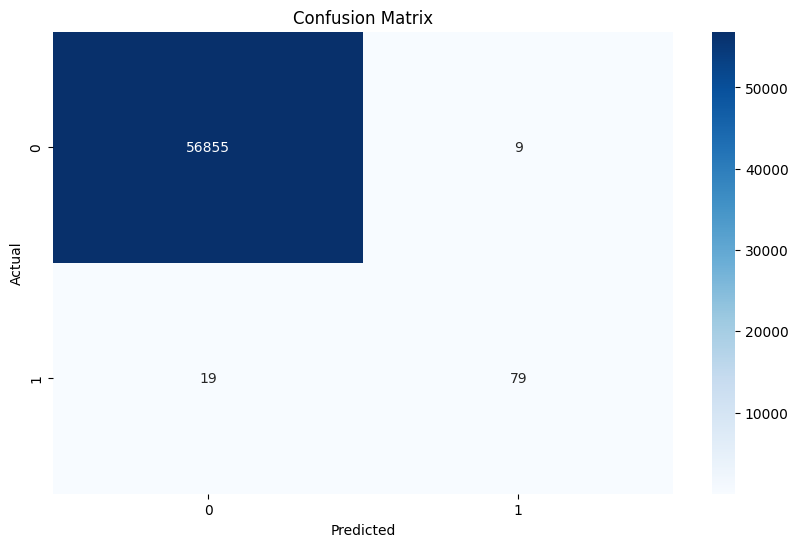

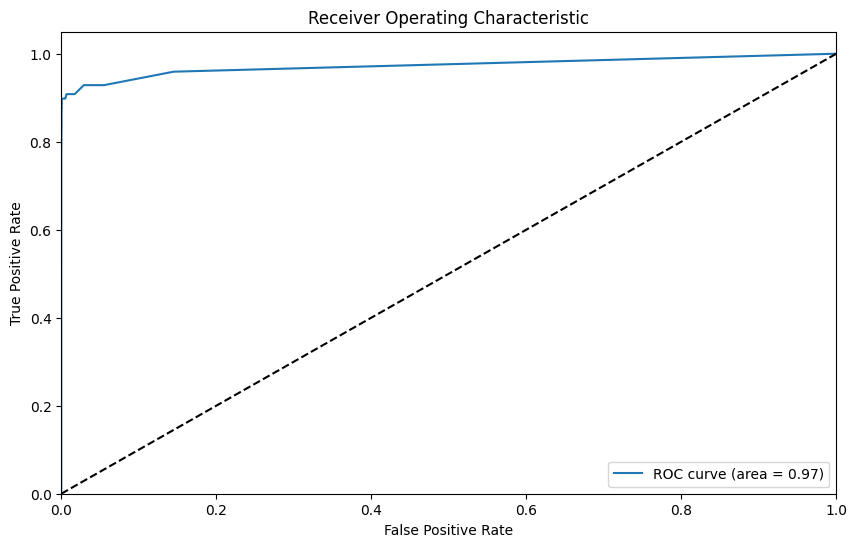

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score


print("accuracy Score: ", accuracy_score(y_test, y_pred))
print("f1 Score: ", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### Confusion Matrix Interpretation
From the confusion matrix:

- True Negatives (TN): 56,855 (Class 0 correctly predicted)

- False Positives (FP): 9 (Class 0 incorrectly predicted as fraud)

- False Negatives (FN): 19 (Fraud missed)

- True Positives (TP): 79 (Fraud correctly detected)

#### Key Observations:
- Accuracy is extremely high but this is expected due to the large class imbalance.

- Recall (Sensitivity) for fraud cases:
    Recall = TP/(TP+FN) = 79/(79+19) = 0.81

    Meaning the model identifies ~81% of actual fraud cases.

- Precision for fraud cases:
    Precision = TP/(TP+FP) = 79/(79+9) = 0.90

    The model has strong precision, minimizing false alarms for fraud.

Very low number of false positives and false negatives means the model is both accurate and effective in flagging fraud, with minimal impact on genuine transactions.

### ROC AUC Plot Interpretation
- AUC (Area Under Curve): 0.97. This is an excellent result—your model is able to distinguish between fraud and non-fraud transactions very well.
 
- ROC curve sits well above the diagonal, showing high separability.

- This metric is especially important for imbalanced data: a high AUC confirms the model's robustness, not just its accuracy.



After thorough feature engineering, class imbalance handling, and hyperparameter tuning, Random Forest emerged as the best-performing model for fraud detection.

The confusion matrix shows extremely high accuracy in identifying non-fraudulent transactions, with only 19 missed fraudulent cases (false negatives) and 79 correctly identified (true positives). Importantly, only 9 legitimate transactions were incorrectly flagged as fraud (false positives), indicating strong precision.

The model's ROC curve yields an outstanding AUC score of 0.97, demonstrating excellent capability in distinguishing fraudulent activity from normal behavior, even in the presence of severe class imbalance.

These metrics validate that the system is both reliable and suitable for real-world deployment: it minimizes risk to genuine users while detecting the vast majority of true fraud cases.

### Feature Importance Analysis and Explainability for Random Forest

Feature Importance and Explainability:
Using the Random Forest model’s native feature importances gives a quick view of the key predictors. However, to understand nuanced interactions and individual predictions, SHAP analysis was employed. SHAP summary plots reveal the top features driving fraud detections, correlate feature values with impact, and show how time-based features (Hour_sin, Hour_cos), scaled Amount, and select PCA components contribute to model decisions. Local explanation plots provide actionable insights at the individual transaction level, crucial for trust and operational use in fraud analytics.

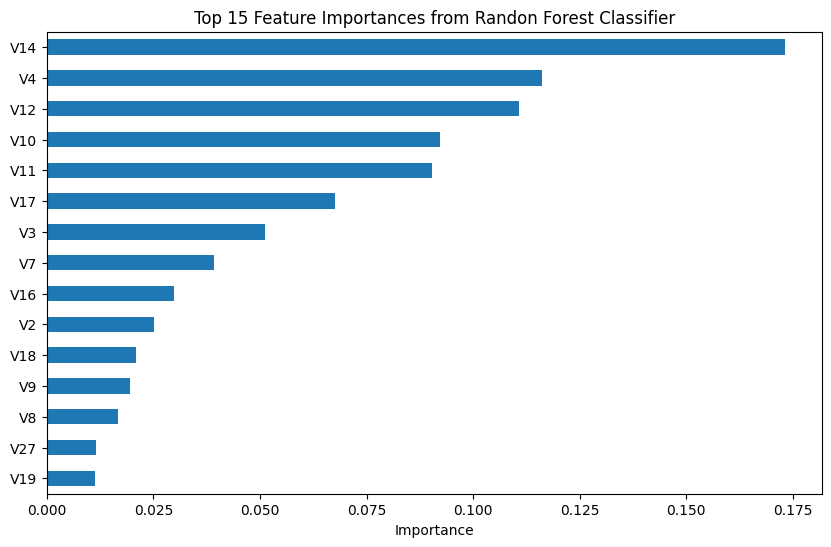

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

feature_names = numeric_features + pcs_features + cyclic_features

# Extract feature importances
importances = model.feature_importances_

# Crate a Dataframe for better visualization
feat_importances = pd.Series(importances, index = feature_names)

# Sort and plot top 15 features
top_features = feat_importances.sort_values(ascending= False).head(15)

# Visualize top 15 features
plt.figure(figsize=(10,6))
top_features.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances from Randon Forest Classifier")
plt.xlabel("Importance")
plt.show()

### Interpretation of Feature Importances

#### What the Chart Shows

- Top 15 Features: The plot displays the 15 most impactful variables according to Random Forest classifier.

- Horizontal Bars: The length of each bar depicts the relative importance of each feature in deciding whether a transaction is fraud or not.

#### Key Insights

- Dominant Features

    - V14, V4, and V12 are the most influential features, with V14 contributing the most to model decisions.

    - These principal components (from PCA) capture statistical patterns in the data and seem highly predictive for fraud.

#### Temporal Feature Impact

- Features like V8, V27, V19, and others, but if time-based engineered features (Hour_sin, Hour_cos, etc.) didn’t make it to the top 15, this suggests the PCA features remain stronger predictors.

#### Why PCA Features Dominate

- The original dataset’s anonymized PCA components contain condensed fraud patterns identified by domain experts.

- Time and Amount features might still add value, but for this dataset, the PCA-derived features are the "heavy lifters."

#### Implications for Modeling & Business Use

- Explainability: Knowing which features drive fraud predictions helps analysts focus their investigations and understand model reasoning.

- Further Analysis: For reporting, highlight that while the new time features can boost detection in some contexts, the anonymized statistical patterns (PCA features) are most influential in this dataset.

The Random Forest model’s feature importance plot reveals that the principal components V14, V4, and V12 are most critical for the detection of fraudulent transactions in this dataset. These top-ranked features significantly outweigh others, indicating that statistical patterns captured through PCA are highly predictive. This aligns with research using this dataset, where certain components consistently correlate with fraud. While engineered time and amount features were included, the PCA features contributed the most signal for our model. These insights provide clarity for model deployment, focusing investigator efforts on transactions with pronounced anomalies in these key components.

### Let us save the model as a pickle file

In [23]:
import os
import pickle

# Ensure the directory exists
os.makedirs('models', exist_ok=True)

# Save the preprocessor
with open('models/preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

# Save the trained model
with open('models/model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Preprocessor and model saved successfully!")

Preprocessor and model saved successfully!
